# Training

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from numpy import float32
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import ClimateHackDataset
from loss import MS_SSIMLoss
from submission.model import Model
import albumentations as A

plt.rcParams["figure.figsize"] = (20, 12)
#torch.rand(10).to(torch.device('cuda'))

/raid/scratch/mbowles/climatehack/venv/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define transformations:
imsize = 64
class scale():
    def __init__(self, limit):
        self.limit = limit
    def __call__(self, image, **kwargs):
        return image/self.limit

transform = A.Compose(
    [
        A.RandomCrop(imsize,imsize),
        A.Lambda(
            name='scale',
            image=scale(1023),
            #target=scale(1023)
        )
        #A.Normalize(mean=0.5, std=0.5, max_pixel_value=1023)
    ],
    additional_targets={'target': 'image'}
)

In [3]:
validation = DataLoader(
    ClimateHackDataset(
        split='train',
        transform=transform,
        target_time_steps=1
    ), 
    batch_size=16, num_workers=8,
    timeout=5, prefetch_factor=2
)

In [4]:
for image, target in validation:
    batch = image
    batch_targets = target
    break
img = batch[0]
y = batch_targets[0]

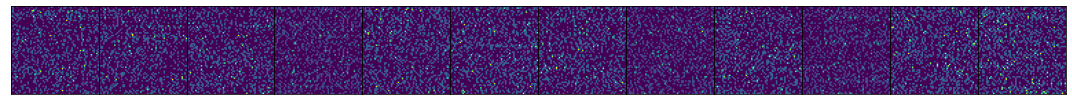

In [5]:
fig, ax = plt.subplots(1, 12, figsize=(15,3))

for i, d in enumerate(img):
    ax[i].imshow(d.squeeze(), cmap='viridis')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

## Creating a model

### Defining constants

In [6]:
BATCH_SIZE = 16
EPOCHS = 1 #100

In [7]:
ch_dataloader = DataLoader(
    ClimateHackDataset(
        split='val',
        transform=transform,
        target_time_steps=24
    ), 
    batch_size=BATCH_SIZE, 
    num_workers=8,
    timeout=5, 
    prefetch_factor=2,
)
for d, t in ch_dataloader:
    print(d.shape, t.shape)
    break

torch.Size([16, 12, 1, 64, 64]) torch.Size([16, 24, 1, 64, 64])


### Instantiating the model

Any models you define need to be in the `submission` folder so that they can be evaluated on DOXA. By default, they are defined in `submission/model.py`, which is where this PyTorch model is defined.

There are some huge improvements you can make to this basic model, so feel free to use this as a starting point and customise `submission/model.py` to your liking!

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# ConvLSTM
# https://github.com/ndrplz/ConvLSTM_pytorch

model = Model(
    input_dim=1,
    hidden_dim=[64, 24],
    kernel_size=(3,3),
    num_layers=2, #8
    batch_first=True,
    bias=True,
    return_all_layers=False
).to(device)


In [10]:
optimiser = optim.Adam(model.parameters(), lr=1e-6)
criterion = MS_SSIMLoss(channels=24) # produces less blurry images than nn.MSELoss()
#criterion = nn.MSELoss()

### Training the model

In [11]:
losses = []
vis = True
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0
    i = 0
    count = 0
    for batch_features, batch_targets in ch_dataloader:
        optimiser.zero_grad()

        batch_targets = batch_targets.squeeze()

        layer_output, last_state  = model(batch_features.to(device))
        batch_predictions = layer_output[0][-1]
        #batch_predictions = last_state[0][0]
        if vis:
            print(len(layer_output[0]), len(last_state[0]))
            print(batch_predictions.shape, batch_targets.shape)
            vis=False
        batch_loss = criterion(
            batch_predictions,
            batch_targets.squeeze().to(device)
        )
        batch_loss.backward()

        optimiser.step()

        running_loss += batch_loss.item() * batch_predictions.shape[0]
        count += batch_predictions.shape[0]
    
    losses.append(running_loss / count)

  0%|          | 0/1 [00:00<?, ?it/s]

12 2
torch.Size([16, 24, 64, 64]) torch.Size([16, 24, 64, 64])


100%|██████████| 1/1 [00:27<00:00, 27.42s/it]


## Visualising the loss

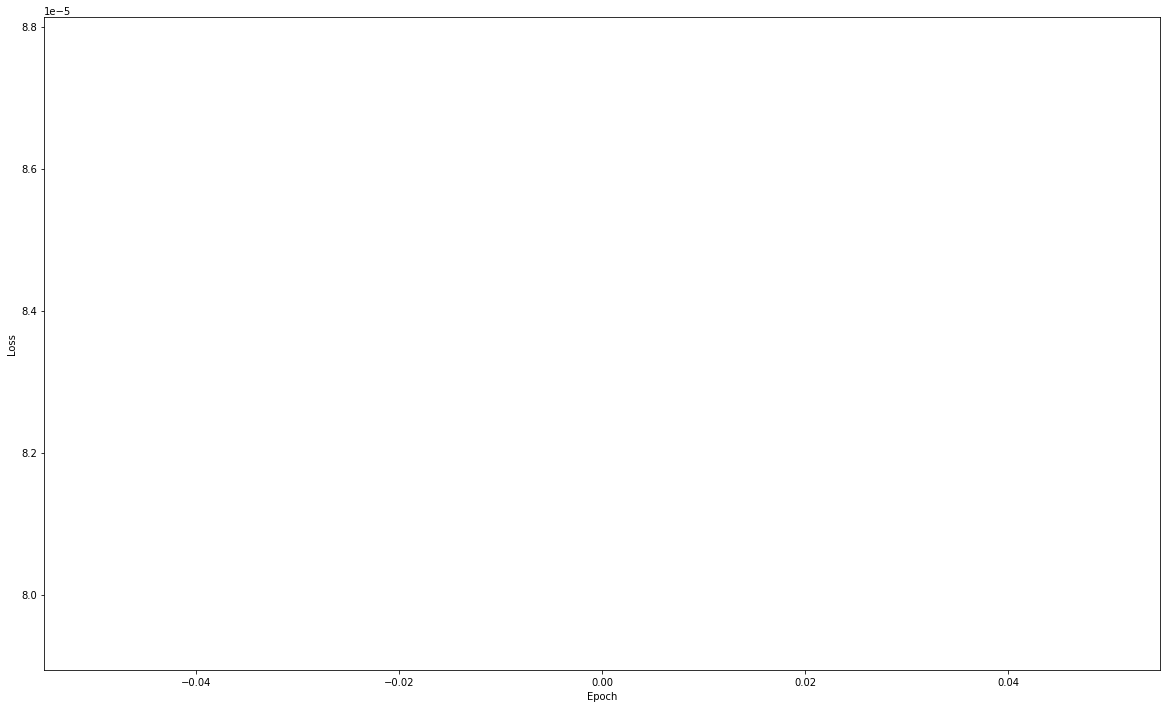

In [12]:
plt.plot(range(EPOCHS), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Visualising its predictions

Having trained the model, it is often useful to visualise some of its predictions to ensure it is producing a sensible output.

(12, 1, 64, 64) (24, 1, 64, 64)


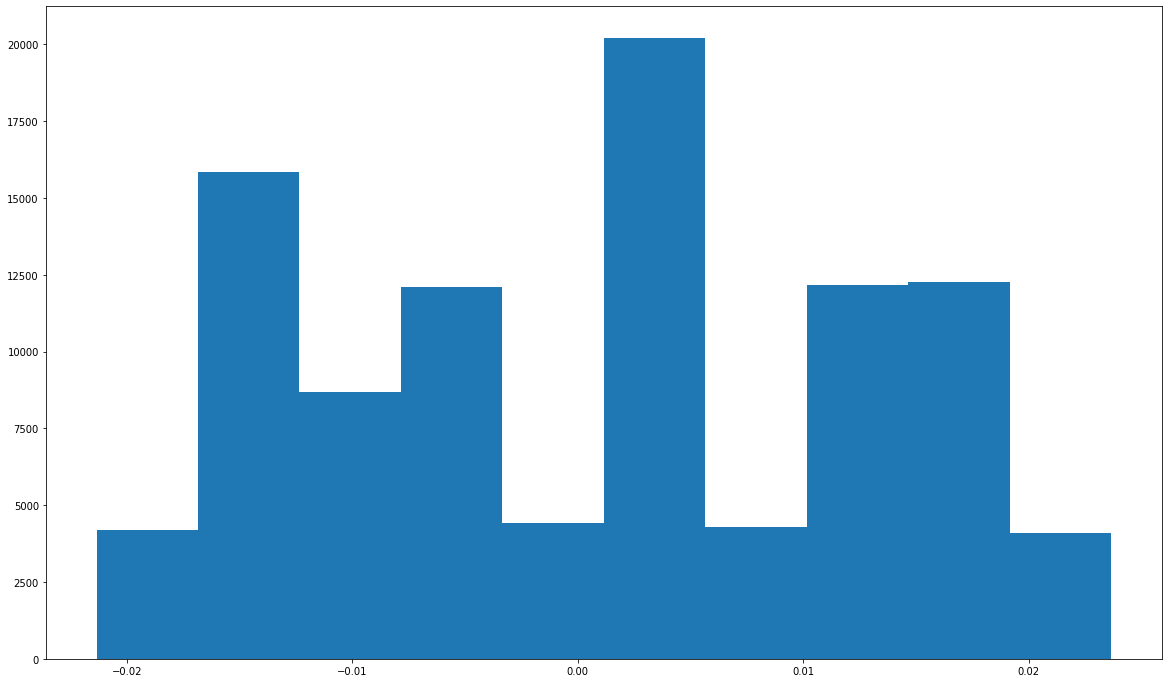

(24, 64, 64)


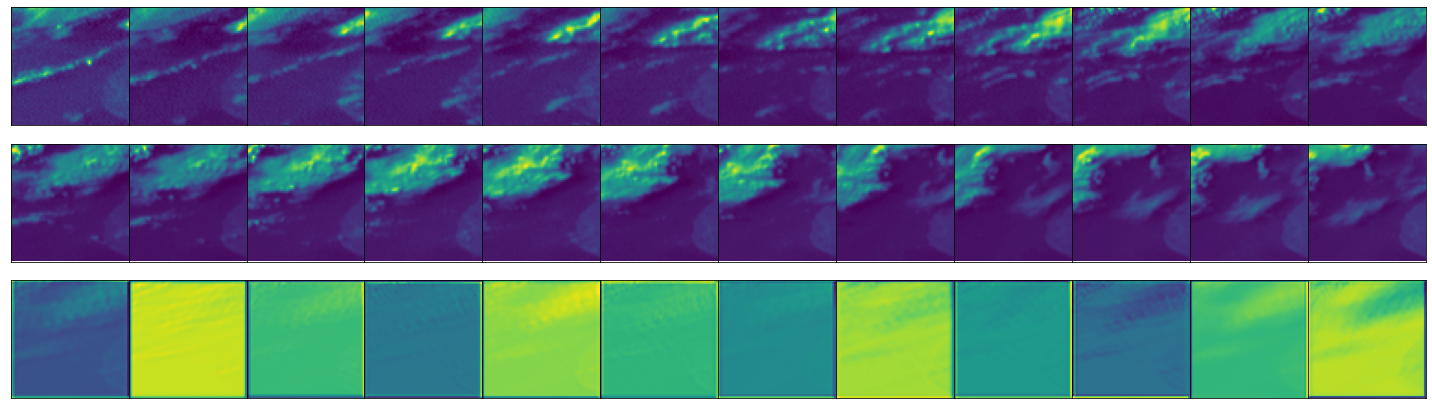

In [15]:
val = ClimateHackDataset(
    split='val',
    transform=transform
)

x, y = val[10]
print(x.shape, y.shape)
#x = validation[0][0]
#y = validation[1][0]
a, b = model(torch.from_numpy(x.astype(float32)).unsqueeze(dim=0).to(device))

p = b[0][0]
p = p.squeeze().cpu().detach().numpy().squeeze()
plt.hist(p.flatten())
plt.show()
print(p.shape)
fig, (ax1, ax2, ax3) = plt.subplots(3, 12, figsize=(20,6))

# plot the twelve 128x128 input images
for i, img in enumerate(x):
    ax1[i].imshow(img.squeeze(), cmap='viridis')
    ax1[i].get_xaxis().set_visible(False)
    ax1[i].get_yaxis().set_visible(False)

# plot twelve 64x64 true output images
for i, img in enumerate(y[:12]):
    ax2[i].imshow(img.squeeze(), cmap='viridis')
    ax2[i].get_xaxis().set_visible(False)
    ax2[i].get_yaxis().set_visible(False)

# plot the twelve 64x64 predicted output images
for i, img in enumerate(p[:12]):
    ax3[i].imshow(img, cmap='viridis')
    ax3[i].get_xaxis().set_visible(False)
    ax3[i].get_yaxis().set_visible(False)

# plot twelve more 64x64 output images
#for i, img in enumerate(p[12:]):
#    ax5[i].imshow(img.cpu().detach().numpy().squeeze(), cmap='viridis')
#    ax5[i].get_xaxis().set_visible(False)
#    ax5[i].get_yaxis().set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

### Saving the model

Having trained the model, it can now be saved in the `submission` folder so that it may be evaluated on [DOXA](https://climatehack.ai/compete).

In [14]:
torch.save(model.state_dict(), 'submission/model.pt')

## Submitting your model to DOXA

Well done -- you made it to the end!

You are now ready to submit your model to DOXA!

If you are not already logged in, run the following command:

```bash
$ python doxa_cli.py user login
```

Finally, to submit your model, upload the entire `submission` folder into which your model was saved using the following command:

```bash
$ python doxa_cli.py agent upload climatehack ./submission
```